In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

# MNIST

In [2]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

X, y = fetch_openml('mnist_784', return_X_y=True)
y = y.astype(np.float32)

# normalizing the RGB codes by dividing it to the max RGB value
X = X / 255

# splitting into train and test data
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

# one-hot-encode the labels
y_train = OneHotEncoder(sparse=False).fit_transform(y_train.reshape(-1, 1))

## MultiLayer Perceptron

In [ ]:
from optiml.ml.neural_network.activations import relu, softmax
from optiml.ml.neural_network.layers import FullyConnected
from optiml.ml.neural_network.losses import categorical_cross_entropy
from optiml.ml.neural_network import NeuralNetworkClassifier
from optiml.ml.utils import plot_model_accuracy, plot_model_loss

from optiml.optimization.unconstrained.stochastic import Adam

from sklearn.metrics import classification_report

mlp = NeuralNetworkClassifier(
    (FullyConnected(784, 100, activation=relu),
     FullyConnected(100, 100, activation=relu),
     FullyConnected(100, 10, activation=softmax)),
    loss=categorical_cross_entropy, optimizer=Adam, learning_rate=0.001, 
    validation_split=0.3, momentum_type='nesterov', momentum=0.5, 
    max_iter=10, batch_size=64, verbose=True)
mlp.fit(X_train, y_train)
plot_model_loss(mlp.train_loss_history, mlp.val_loss_history)
plot_model_accuracy(mlp.train_score_history, mlp.val_score_history)
print(classification_report(y_test, mlp.predict(X_test)))

epoch	iter	cost	
   0	 657	1.1017e-01	loss: 1.4729e-01 - val_loss: 7.9603e-02 - acc: 0.9375 - val_acc: 0.9496
   1	1314	8.3128e-02	loss: 6.1728e-02 - val_loss: 8.2330e-02 - acc: 0.9531 - val_acc: 0.9454
   2	1971	5.0471e-02	loss: 4.2656e-02 - val_loss: 6.6005e-02 - acc: 0.9688 - val_acc: 0.9599
   3	2628	3.1533e-02	loss: 3.0378e-02 - val_loss: 6.0948e-02 - acc: 0.9844 - val_acc: 0.9652

## Convolutional Neural Network

In [4]:
# reshaping the images data to a tensor of shape
# (n_samples, image_height, image_width, n_channels)
# for convolution layers
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

epoch	iter	f(x)	
   0	 750	6.9188e-03	loss: 1.8459e-02 - val_loss: 1.7071e-02 - acc: 0.9688 - val_acc: 0.9569
   1	1500	1.1779e-02	loss: 1.1851e-02 - val_loss: 1.6523e-02 - acc: 0.9844 - val_acc: 0.9640
   2	2250	1.7550e-02	loss: 1.0890e-02 - val_loss: 1.3765e-02 - acc: 0.9688 - val_acc: 0.9706
   3	3000	2.0363e-02	loss: 1.1133e-02 - val_loss: 2.1897e-02 - acc: 0.9688 - val_acc: 0.9635
   4	3750	2.2013e-02	loss: 1.2015e-02 - val_loss: 1.3935e-02 - acc: 0.9688 - val_acc: 0.9718



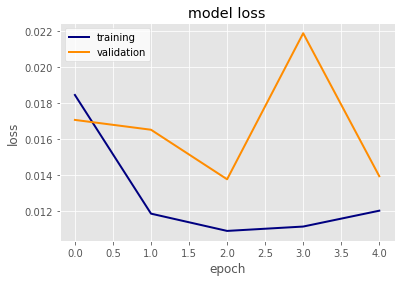

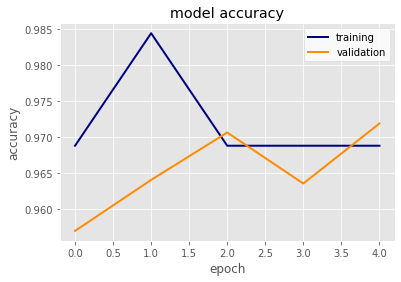

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       980
         1.0       0.98      1.00      0.99      1135
         2.0       0.97      0.97      0.97      1032
         3.0       0.99      0.97      0.98      1010
         4.0       0.96      0.98      0.97       982
         5.0       0.98      0.98      0.98       892
         6.0       0.97      0.99      0.98       958
         7.0       0.95      0.97      0.96      1028
         8.0       0.98      0.94      0.96       974
         9.0       0.98      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [5]:
from optiml.ml.neural_network.activations import relu, softmax
from optiml.ml.neural_network.layers import Conv2D, MaxPool2D, Flatten, FullyConnected
from optiml.ml.neural_network.losses import categorical_cross_entropy
from optiml.ml.neural_network import NeuralNetworkClassifier
from optiml.ml.utils import plot_model_accuracy, plot_model_loss

from optiml.optimization.unconstrained.stochastic import Adam

from sklearn.metrics import classification_report

cnn = NeuralNetworkClassifier(
    (Conv2D(in_channels=1, out_channels=6, kernel_size=(5, 5), strides=(1, 1),
            padding='same', channels_last=True, activation=relu),  # (n_samples, 28, 28, 6)
     MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # (n_samples, 14, 14, 6)
     Conv2D(in_channels=6, out_channels=16, kernel_size=(5, 5), strides=(1, 1),
            padding='same', channels_last=True, activation=relu),  # (n_samples, 14, 14, 16)
     MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # (n_samples, 7, 7, 16)
     Flatten(),  # (n_samples, 7 * 7 * 16)
     FullyConnected(n_in=7 * 7 * 16, n_out=10, activation=softmax)),
    loss=categorical_cross_entropy, optimizer=Adam, learning_rate=0.01, 
    validation_split=0.2, momentum_type='nesterov', momentum=0.5, 
    max_iter=5, batch_size=64, verbose=True)
cnn.fit(X_train, y_train)
plot_model_loss(cnn.train_loss_history, cnn.val_loss_history)
plot_model_accuracy(cnn.train_score_history, cnn.val_score_history)
print(classification_report(y_test, cnn.predict(X_test)))